# **Audio Recognition**

This project demonstrates how to preprocess audio files in the MP3 format, convert them to WAV, build and train a automatic speech recognition (ASR) model for recognizing twelve different words. I used a small dataset, which contains short audio clips of commands, such as "اوراق","ارز","سکه","بانک","طلا","نفت","مشتقات","فلزات","صندوق سهامی","صندوق درآمد ثابت","صندوق مختلط","صندوق قابل معامله".

# Preprocessing

First extract the data

In [1]:
import zipfile

zip_file_path = '12words.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('')

Install dependencies

In [2]:
!pip install pydub
!pip install -U -q tensorflow tensorflow_datasets
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 10.8 MB/s eta 0:00:00


In [84]:
import os
import glob
from pydub import AudioSegment
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import json
import seaborn as sns
import numpy as np
import pandas as pd
import wave
from scipy.signal import resample
import soundfile as sf
import tensorflow_io as tfio
import librosa
from IPython import display
import keras
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = "data"
ORIGINAL_DATA_PATH = '12words'

Create data labels dictionary to rename data folders

In [5]:
dataLabels = ["اوراق","ارز","سکه","بانک","طلا","نفت","مشتقات","فلزات","صندوق سهامی","صندوق درآمد ثابت","صندوق مختلط","صندوق قابل معامله"]

In [6]:
old_folder_path = ORIGINAL_DATA_PATH
new_folder_name = DATA_PATH
os.rename(old_folder_path, new_folder_name)

A simple function to rename dirs to original data labels

In [7]:
def renameDirs():
    path = DATA_PATH
    folder_names = dataLabels
    folders = sorted(os.listdir(path), key= int)
    for i, folder in enumerate(folders):
        print(i)
        print(f"folder name : {folder}")
        old_folder_path = os.path.join(path, folder)
        new_folder_name = folder_names[i]
        new_folder_path = os.path.join(path, new_folder_name)
        os.rename(old_folder_path, new_folder_path)
    print("Folders have been renamed.")

In [8]:
renameDirs()

0
folder name : 1
1
folder name : 3
2
folder name : 4
3
folder name : 5
4
folder name : 7
5
folder name : 8
6
folder name : 9
7
folder name : 11
8
folder name : 13
9
folder name : 15
10
folder name : 17
11
folder name : 19
Folders have been renamed.


At first step to use our data is to convert them to WAV format as we need to see waveforms and extract spectrograms.

In [9]:
def convertMp3ToWav(sourceAddress, outputAddress=None):

    if not outputAddress:
        outputAddress = sourceAddress

    os.makedirs(outputAddress, exist_ok=True)
    for subdir in os.listdir(sourceAddress):
        if os.path.isdir(os.path.join(sourceAddress, subdir)):
            subdirectory_path = os.path.join(sourceAddress, subdir)
            convertMp3ToWav(subdirectory_path, outputAddress=os.path.join(outputAddress, subdir))
    for mp3_file in glob.glob(os.path.join(sourceAddress, "*.mp3")):
        wav_filename = os.path.splitext(os.path.basename(mp3_file))[0] + ".wav"
        wav_path = os.path.join(outputAddress, wav_filename)

        try:
            sound = AudioSegment.from_mp3(mp3_file)

            sound.export(wav_path, format="wav", codec="pcm_s16le")
            os.remove(mp3_file)
            print(f"Converted '{mp3_file}' to '{wav_path}' successfully!")
        except Exception as e:
            print(f"Error converting '{mp3_file}': {e}")


In [10]:
convertMp3ToWav(DATA_PATH)

Converted 'data/صندوق سهامی/30-(13).mp3' to 'data/صندوق سهامی/30-(13).wav' successfully!
Converted 'data/صندوق سهامی/20-(13).mp3' to 'data/صندوق سهامی/20-(13).wav' successfully!
Converted 'data/صندوق سهامی/35-(13).mp3' to 'data/صندوق سهامی/35-(13).wav' successfully!
Converted 'data/صندوق سهامی/17-(13).mp3' to 'data/صندوق سهامی/17-(13).wav' successfully!
Converted 'data/صندوق سهامی/7-(13).mp3' to 'data/صندوق سهامی/7-(13).wav' successfully!
Converted 'data/صندوق سهامی/19-(13).mp3' to 'data/صندوق سهامی/19-(13).wav' successfully!
Converted 'data/صندوق سهامی/9-(13).mp3' to 'data/صندوق سهامی/9-(13).wav' successfully!
Converted 'data/صندوق سهامی/13-(13).mp3' to 'data/صندوق سهامی/13-(13).wav' successfully!
Converted 'data/صندوق سهامی/26-(13).mp3' to 'data/صندوق سهامی/26-(13).wav' successfully!
Converted 'data/صندوق سهامی/28-(13).mp3' to 'data/صندوق سهامی/28-(13).wav' successfully!
Converted 'data/صندوق سهامی/24-(13).mp3' to 'data/صندوق سهامی/24-(13).wav' successfully!
Converted 'data/صندوق سها

Now we should downsample the data from 44KHz to 16KHz for better performance in training.

In [11]:
def downsampleTo16K():
    targetSampleRate = 16000
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.endswith(".wav"):
                wav_file = os.path.join(root, file)
                data, sample_rate = sf.read(wav_file)
                if sample_rate == targetSampleRate:
                    continue
                resampled_data = resample(data, int(len(data) * targetSampleRate / sample_rate))
                sf.write(wav_file, resampled_data, targetSampleRate, 'PCM_16')
                print(f"Downsampled {wav_file} to {targetSampleRate} Hz")

In [12]:
downsampleTo16K()

Downsampled data/صندوق سهامی/11-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/13-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/3-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/21-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/10-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/26-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/24-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/30-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/35-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/15-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/38-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/17-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/33-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/6-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/28-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/20-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/23-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/32-(13).wav to 16000 Hz
Downsampled data/صندوق سهامی/22-(13).wav to 1600

## Data Augmentation

Our dataset is so small to train to achieve better accuracy we should use data augmentation to produce more data

We want to produce data using 4 method:


1.   Pitch Shifting
2.   Time Shifting
3.   TIme Stretching

In [13]:
def timeStretching():
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')):
                wav = os.path.join(root, file)
                data, sample_rate = sf.read(wav)
                factor = 0.8
                wav_time_stch = librosa.effects.time_stretch(data,rate = factor)
                out = os.path.join(root, 'time_stretching'+ file)
                print(f'Time stretching of the {wav}')
                sf.write(out, wav_time_stch, sample_rate)


def lowPitchShifting():
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')):
                wav = os.path.join(root, file)
                data, sample_rate = sf.read(wav)
                wav_pitch_sf = librosa.effects.pitch_shift(data,sr = sample_rate,n_steps=-2)
                out = os.path.join(root, 'low_pitch_shift'+ file)
                print(f'change pitch the wave {wav}')
                sf.write(out, wav_pitch_sf, sample_rate)

def highPitchShifting():
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')):
                wav = os.path.join(root, file)
                data, sample_rate = sf.read(wav)
                wav_pitch_sf = librosa.effects.pitch_shift(data,sr = sample_rate,n_steps=2)
                out = os.path.join(root, 'high_pitch_shift'+ file)
                print(f'change pitch the wave {wav}')
                sf.write(out, wav_pitch_sf, sample_rate)


def timeShifting():
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            if file.startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')):
                wav = os.path.join(root, file)
                data, sample_rate = sf.read(wav)
                wav_roll = np.roll(data,int(sample_rate/10))
                out = os.path.join(root, 'time_shift'+ file)
                print(f'Shfiting {wav} by Times {sample_rate/10}')
                sf.write(out, wav_roll, sample_rate)


In [14]:
highPitchShifting()
lowPitchShifting()
timeShifting()
timeStretching()

change pitch the wave data/صندوق سهامی/11-(13).wav
change pitch the wave data/صندوق سهامی/13-(13).wav
change pitch the wave data/صندوق سهامی/3-(13).wav
change pitch the wave data/صندوق سهامی/21-(13).wav
change pitch the wave data/صندوق سهامی/10-(13).wav
change pitch the wave data/صندوق سهامی/26-(13).wav
change pitch the wave data/صندوق سهامی/24-(13).wav
change pitch the wave data/صندوق سهامی/30-(13).wav
change pitch the wave data/صندوق سهامی/35-(13).wav
change pitch the wave data/صندوق سهامی/15-(13).wav
change pitch the wave data/صندوق سهامی/38-(13).wav
change pitch the wave data/صندوق سهامی/17-(13).wav
change pitch the wave data/صندوق سهامی/33-(13).wav
change pitch the wave data/صندوق سهامی/6-(13).wav
change pitch the wave data/صندوق سهامی/28-(13).wav
change pitch the wave data/صندوق سهامی/20-(13).wav
change pitch the wave data/صندوق سهامی/23-(13).wav
change pitch the wave data/صندوق سهامی/32-(13).wav
change pitch the wave data/صندوق سهامی/22-(13).wav
change pitch the wave data/صندوق 

Show waveforms to see changes on a sample file

In [83]:
def plot_spec(path,title) -> None:
  spf = read(path)
  signal = spf[1]
  plt.plot(signal)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title(title)
  plt.show()

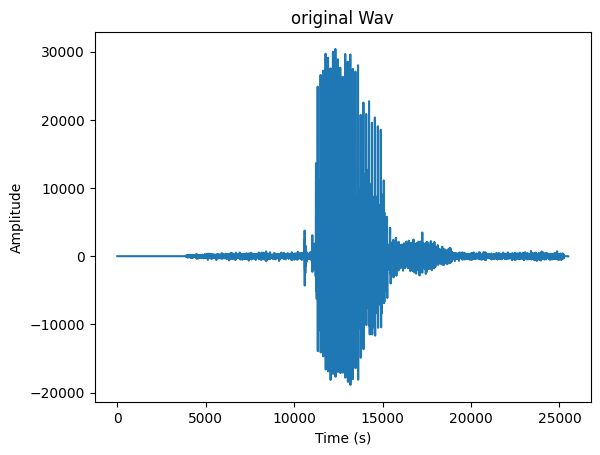

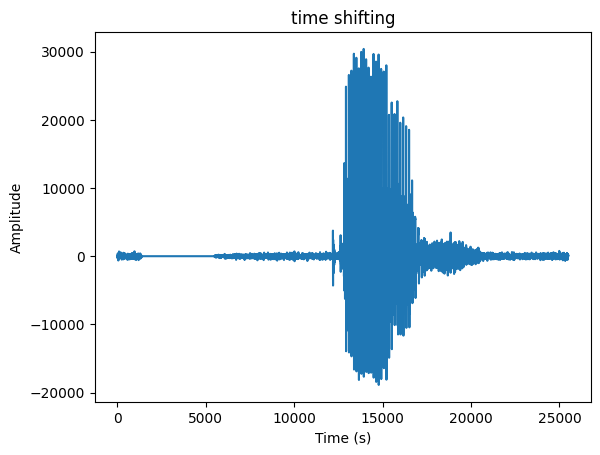

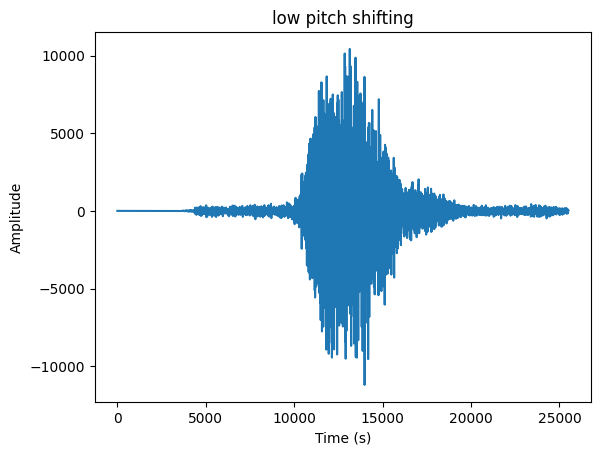

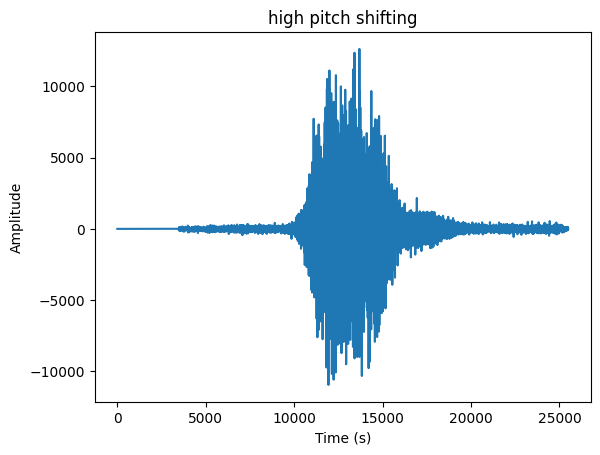

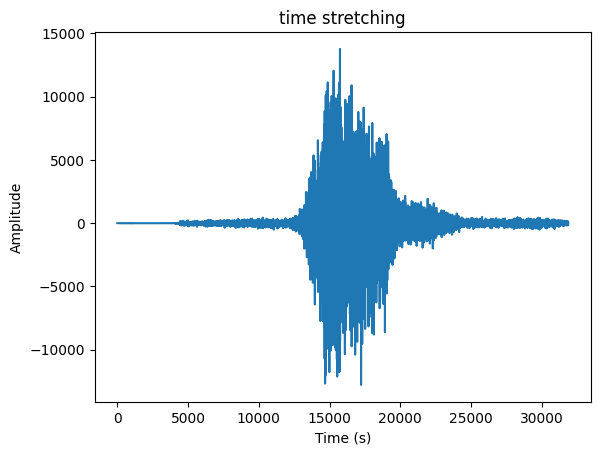

In [81]:

plot_spec("/content/data/ارز/1-(3).wav" ,"original Wav" )
plot_spec("/content/data/ارز/time_shift1-(3).wav" ,"time shifting" )
plot_spec("/content/data/ارز/low_pitch_shift1-(3).wav" ,"low pitch shifting" )
plot_spec("/content/data/ارز/high_pitch_shift1-(3).wav" ,"high pitch shifting" )
plot_spec("/content/data/ارز/time_stretching1-(3).wav" ,"time stretching" )


Now we have to read audio file. It's better to see their average length and the longest length to create train , test and validation set

In [17]:
def dataInfo():
    subdirectories = []
    bitrates = []
    lengths = []
    longest = []
    for dirpath, dirnames, filenames in os.walk(DATA_PATH):
        longest_length = 0
        for filename in filenames:
            if filename.endswith('.wav'):
                file_path = os.path.join(dirpath, filename)
                with wave.open(file_path, 'rb') as wav_file:
                    frames = wav_file.getnframes()
                    channels = wav_file.getnchannels()
                    sample_width = wav_file.getsampwidth()
                    frame_rate = wav_file.getframerate()
                    bitrate = frame_rate * sample_width * 8 * channels
                    duration = frames / frame_rate
                    subdirectories.append(dirpath)
                    bitrates.append(bitrate)
                    lengths.append(duration)
                    if longest_length < duration:
                        longest_length = duration
        if longest_length != 0:
            longest.append(longest_length)

    data = {
    'Subdirectory': subdirectories,
    'Average Bitrate': bitrates,
    'Average Length': lengths
    }
    df = pd.DataFrame(data)
    grouped_df = df.groupby('Subdirectory').mean()
    grouped_df["longest"] = longest
    print(grouped_df)

In [18]:
dataInfo()

                        Average Bitrate  Average Length   longest
Subdirectory                                                     
data/ارز                       256000.0        2.238827  5.942812
data/اوراق                     256000.0        2.339628  5.779500
data/بانک                      256000.0        2.252543  4.342812
data/سکه                       256000.0        2.355398  4.342812
data/صندوق درآمد ثابت          256000.0        3.521801  4.506125
data/صندوق سهامی               256000.0        2.955396  6.302000
data/صندوق قابل معامله         256000.0        3.428539  3.983687
data/صندوق مختلط               256000.0        3.013687  8.293812
data/طلا                       256000.0        2.282710  4.506125
data/فلزات                     256000.0        2.570024  5.224437
data/مشتقات                    256000.0        2.695510  7.934687
data/نفت                       256000.0        2.321800  5.224437


As we can see the longest file is about 8 sec long and the ceiling of average is 4 sec, so it is better to read 4 sec from audio files, so we should set ```
output_sequence_length=16000*4```
and split data to train and val dataset


In [19]:
data_dir = pathlib.Path(DATA_PATH)
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
directory=data_dir,
batch_size=32,
validation_split=0.2,
seed=42,
output_sequence_length=16000*4,
subset='both')

Found 2400 files belonging to 12 classes.
Using 1920 files for training.
Using 480 files for validation.


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [20]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels


In [21]:
dataLabels = np.array(train_ds.class_names)
print(train_ds.element_spec)
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

(TensorSpec(shape=(None, 64000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from validation set.
in this case we can use `Dataset.shard` to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction.

In [22]:

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels)

(32, 64000)
tf.Tensor(
[ 6  1  4  4  2  1  2  6  7  5  1  8  9  8  0  2 10 11 11  1 11 10  3  1
  1  8  5  5  1  0 10  3], shape=(32,), dtype=int32)


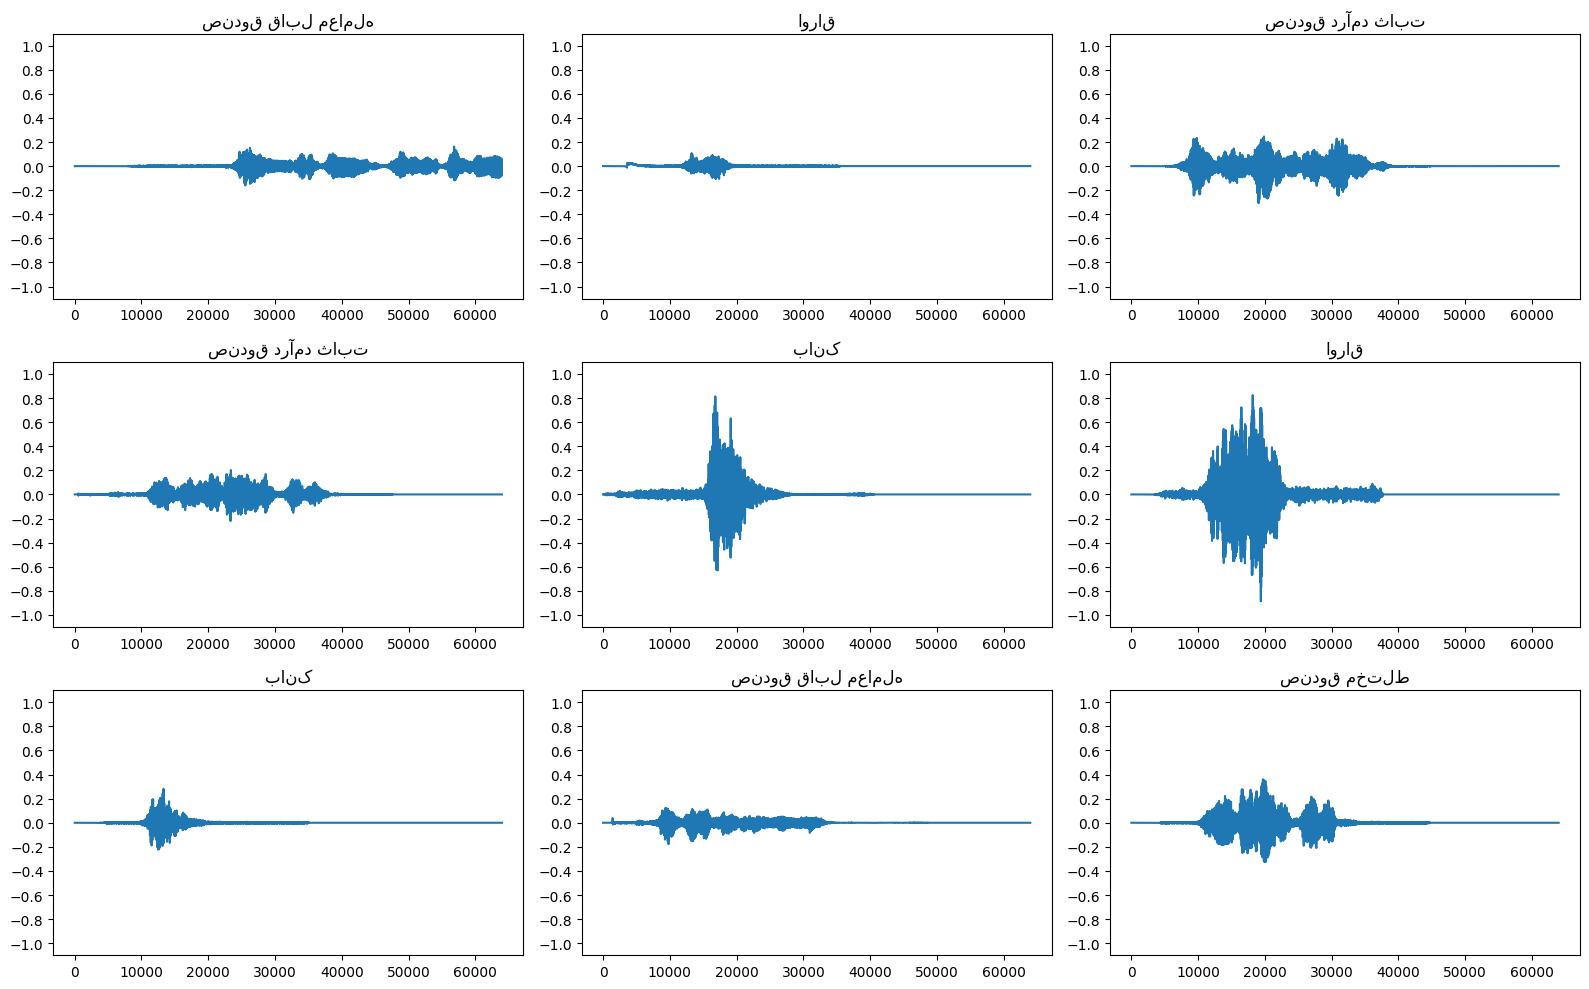

In [23]:
#show plot of few waveforms
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(dataLabels[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])
  plt.tight_layout()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, we transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. We will feed the spectrogram images into the neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that we can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when we convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost rectangle.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial we only use the magnitude, which we can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [24]:
def getSpectrogram(waveform,nfft=216,window=512,stride = 256):
    spectrogram = tfio.audio.spectrogram(
    waveform, nfft=nfft, window=window, stride=stride)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def makeSpecDs(ds):
    return ds.map(
        map_func=lambda audio,label: (getSpectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [25]:
for i in range(3):
    label = dataLabels[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = getSpectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    display.display(display.Audio(waveform, rate=16000))

Label: صندوق قابل معامله
Waveform shape: (64000,)
Spectrogram shape: (250, 109, 1)


Label: اوراق
Waveform shape: (64000,)
Spectrogram shape: (250, 109, 1)


Label: صندوق درآمد ثابت
Waveform shape: (64000,)
Spectrogram shape: (250, 109, 1)


Now, define a function for displaying a spectrogram:

In [26]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

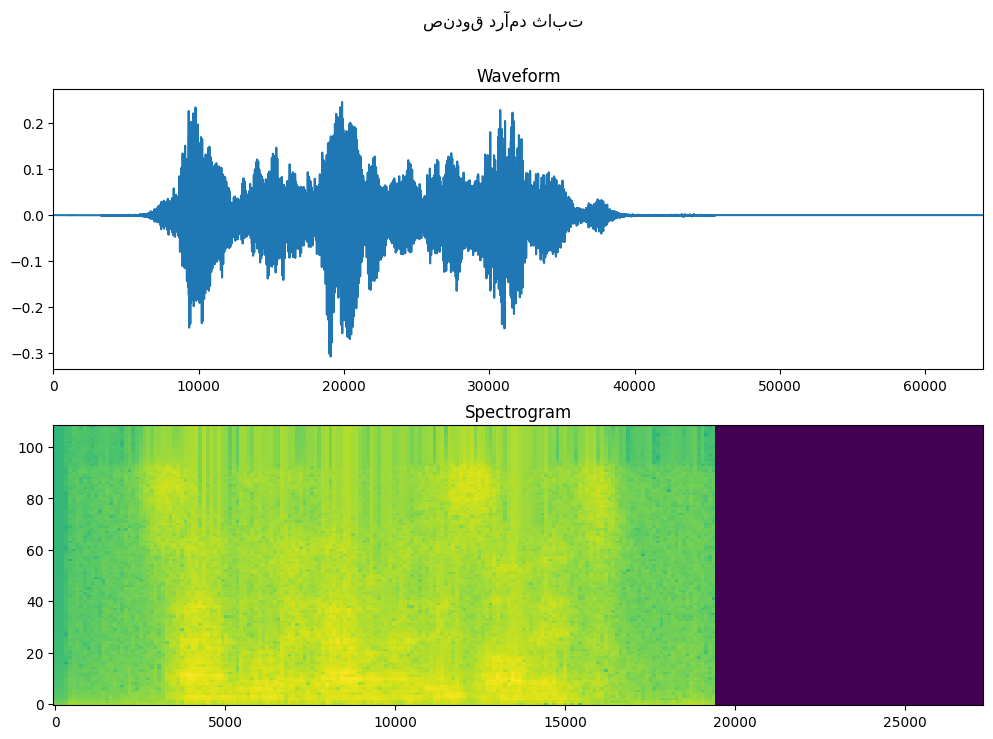

In [27]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000*4])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:


In [28]:
train_spectrogram_ds = makeSpecDs(train_ds)
val_spectrogram_ds = makeSpecDs(val_ds)
test_spectrogram_ds = makeSpecDs(test_ds)

Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

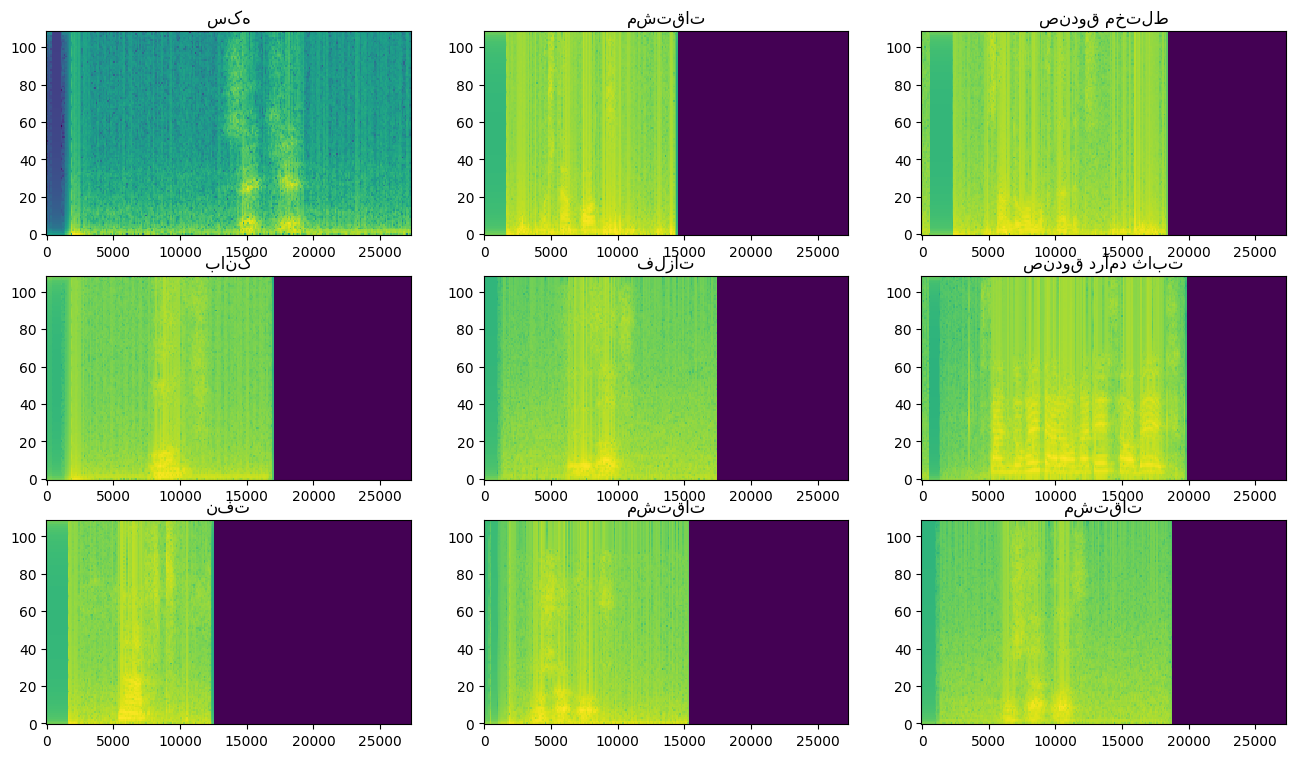

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(dataLabels[example_spect_labels[i].numpy()])

plt.show()

# Build and train the model

For the model, I used a simple convolutional neural network (CNN).

`tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

What I used for the model :

- The Resizing layer resizes the input spectrograms to a target size of 64x64 pixels.
- The Normalization layer normalizes the input spectrograms.
- Two Conv2D layers with 32 and 16 filters, respectively, apply convolutional operations to extract features from the input data. The activation function used is ReLU.
- The MaxPooling2D layer performs down-sampling, reducing the spatial dimensions of the feature maps while preserving important information.
- The Flatten layer flattens the multi-dimensional feature maps into a 1D vector.
- The Dense layer with 64 units and ReLU activation applies a fully connected layer to learn higher-level representations.
- The Dropout layer helps prevent overfitting by randomly dropping out a fraction of the connections during training.
- The final Dense layer with num_labels units and softmax activation produces the output probabilities for each class.


In [48]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(dataLabels)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    # Downsample the input.
    keras.layers.Resizing(64, 64),
    # Normalize.
    norm_layer,
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels,activation = 'softmax'),
])
model.summary()

Input shape: (250, 109, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)       

Configure the Keras model with the Adam optimizer and the cross-entropy loss:




In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model over 15 epochs for demonstration purposes.
```callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)``` will stop the training when it saw the validation loss goes up after two sequence epoch

In [50]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/15
60/60 [==============================] - 17s 258ms/step - loss: 2.4444 - accuracy: 0.1406 - val_loss: 2.2987 - val_accuracy: 0.2366
Epoch 2/15
60/60 [==============================] - 16s 270ms/step - loss: 2.1528 - accuracy: 0.2620 - val_loss: 1.9961 - val_accuracy: 0.3571
Epoch 3/15
60/60 [==============================] - 17s 278ms/step - loss: 1.8776 - accuracy: 0.3365 - val_loss: 1.6952 - val_accuracy: 0.4911
Epoch 4/15
60/60 [==============================] - 18s 285ms/step - loss: 1.6210 - accuracy: 0.4276 - val_loss: 1.5414 - val_accuracy: 0.5312
Epoch 5/15
60/60 [==============================] - 16s 258ms/step - loss: 1.4232 - accuracy: 0.4979 - val_loss: 1.4479 - val_accuracy: 0.5402
Epoch 6/15
60/60 [==============================] - 18s 302ms/step - loss: 1.3636 - accuracy: 0.5068 - val_loss: 1.3671 - val_accuracy: 0.6116
Epoch 7/15
60/60 [==============================] - 18s 292ms/step - loss: 1.1669 - accuracy: 0.5786 - val_loss: 1.3481 - val_accuracy: 0.5804

Plot the training and validation loss curves to check how the model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

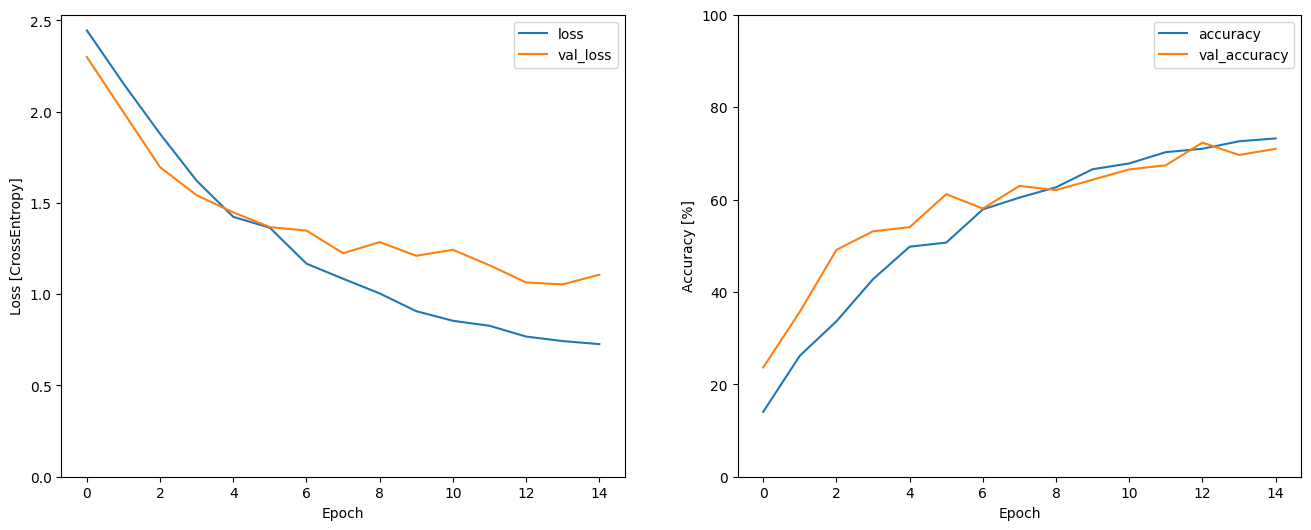

In [63]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

# Evaluate the model performance

Run the model on the test set and check the model's performance:

In [64]:
model.evaluate(test_spectrogram_ds, return_dict=True)

8/8 [==============================] - 1s 106ms/step - loss: 0.7512 - accuracy: 0.7812


{'loss': 0.7511847019195557, 'accuracy': 0.78125}

## Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [65]:
y_pred = model.predict(test_spectrogram_ds)

8/8 [==============================] - 1s 108ms/step


In [66]:
y_pred = tf.argmax(y_pred, axis=1)

In [67]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

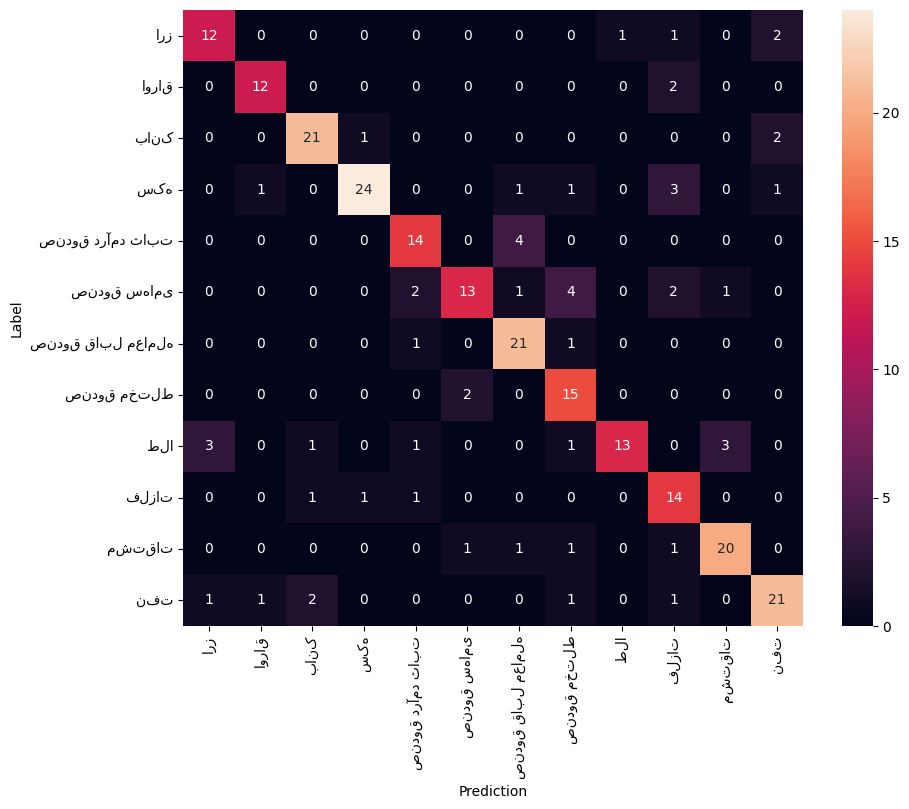

In [68]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=dataLabels,
            yticklabels=dataLabels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "بانک".

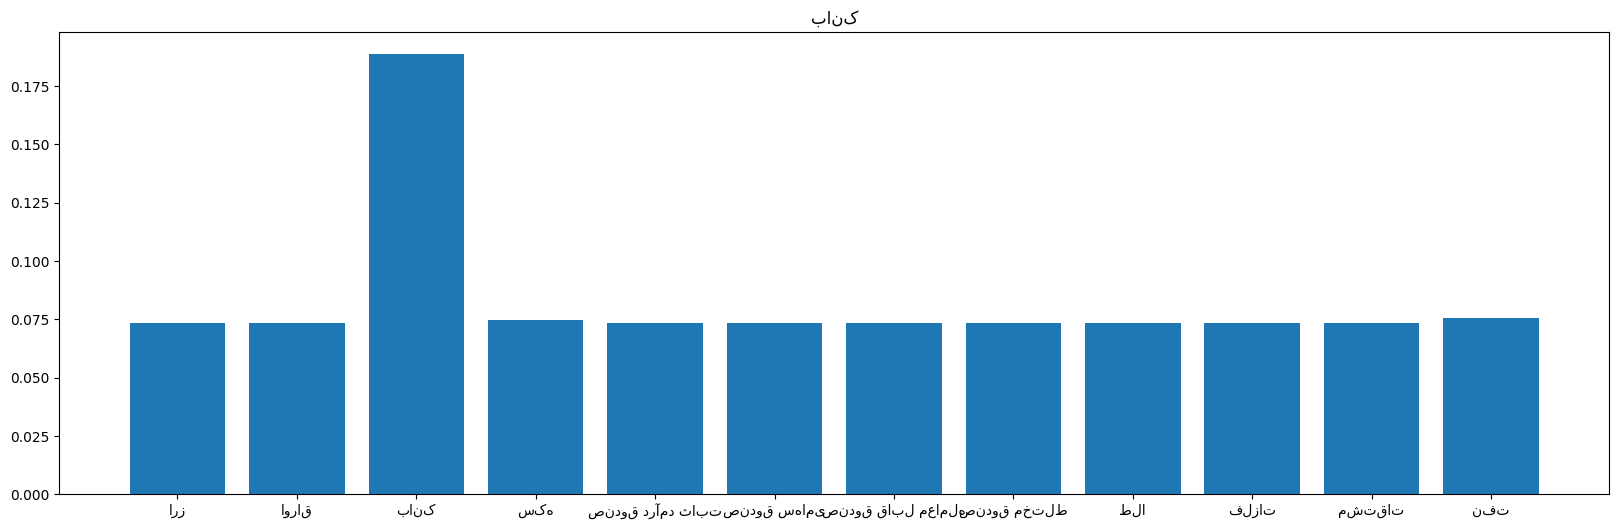

In [69]:
x = 'data/بانک/14-(5).wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000*4,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = getSpectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.figure(figsize=(20, 6))
plt.bar(dataLabels, tf.nn.softmax(prediction[0]))
plt.title('بانک')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Export the model with preprocessing

We have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [70]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000*4], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000*4,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = getSpectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(dataLabels, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [90]:
export = ExportModel(model)
export(tf.constant('data/بانک/14-(5).wav'))

{'predictions': <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[1.9646476e-03, 9.5706125e-04, 9.4461584e-01, 1.7604377e-02,
         4.7038594e-07, 8.6173019e-04, 8.4774103e-07, 3.0660590e-06,
         5.2673695e-05, 6.7487435e-04, 2.1207843e-03, 3.1143537e-02]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'\xd8\xa8\xd8\xa7\xd9\x86\xda\xa9'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [91]:
tf.saved_model.save(export, "model")
imported = tf.saved_model.load("model")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'\xd8\xa8\xd8\xa7\xd9\x86\xda\xa9'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[1.9646476e-03, 9.5706125e-04, 9.4461584e-01, 1.7604377e-02,
         4.7038594e-07, 8.6173019e-04, 8.4774103e-07, 3.0660590e-06,
         5.2673695e-05, 6.7487435e-04, 2.1207843e-03, 3.1143537e-02]],
       dtype=float32)>}

In [73]:
prediction = imported('data/ارز/1-(3).wav')
prediction['class_names'][0].numpy().decode('utf-8')

'ارز'